# Problem Statement: Airbnb Hotel Booking Analysis

The exponential growth of short-term rental platforms such as Airbnb has transformed the global hospitality sector. However, this surge has also created challenges in understanding the dynamics that drive property pricing, host performance, and customer satisfaction. This project aims to conduct a comprehensive exploratory data analysis (EDA) of Airbnb listings in New York City to uncover determinants of pricing, availability, and review performance. Using advanced data visualization and statistical methods, this study investigates the interplay between property characteristics, neighborhood profiles, host credibility, and customer feedback.

# QUESTIONS
This project is aimed to uncover some insights from the Airbnb Open Data, The following questions would be answered from the data,
1. What are the different property types in the Dataset?
2. Which neighborhood group has the highest number of listings?
3. Which neighborhoods group have the highest average prices for Airbnb listings?
4. Is there a relationship between the construction year of property and price?
5. Who are the top 10 hosts by calculated host listing count?
6. Are hosts with verified identities more likely to receive positive reviews?
7. Is there a correlation between the price of a listing and its service fee?
8. What is the avyerage review rate number (e.g., stars) for listings, and does it vary based on the neighborhood group and room type?
9. Are hosts with a higher calculated host listings count more likely to maintain higher availability throughout the year?

# DATA WRANGLING

Data wrangling, a crucial phase in the data analysis process, involves preparing and cleaning raw data to make it suitable for analysis. This involves various tasks such as handling missing values, removing duplicates, and transforming data into a consistent format, Effective data wrangling ensures that the data is reliable and ready for exploration, enabling meaningful insights to be derived from it.

## Setup & Data Loading

In [1]:
# Install dependencies
!pip install --quiet openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.0)
plt.rcParams['figure.figsize'] = (10,5)

# ---- Load dataset from Google Drive ----
DRIVE_FILE_ID = "1eMJ4mEQ-C8-Cao0brstPAKyuNqGcHmBC"
url = f"https://drive.google.com/uc?id={DRIVE_FILE_ID}"

try:
    df = pd.read_csv(url, low_memory=False)
    print(" CSV loaded successfully from Google Drive")
except Exception as e_csv:
    try:
        df = pd.read_excel(url)
        print(" Excel file loaded successfully from Google Drive")
    except Exception as e_xls:
        raise RuntimeError(f" Dataset loading failed: {e_csv} | {e_xls}")

print("Shape:", df.shape)
df.head()


 CSV loaded successfully from Google Drive
Shape: (102599, 26)


,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,193.0,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,28.0,30.0,45.0,05/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,124.0,3.0,0.0,NaN,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,74.0,30.0,270.0,07/05/2019,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,41.0,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


## Preprocessing & Column Mapping

In [2]:
# Normalize column names
def normalize(cols):
    return [str(c).strip().lower().replace(" ", "_").replace("-", "_") for c in cols]

df.columns = normalize(df.columns)
df = df.drop_duplicates().reset_index(drop=True)

# Convert obvious numeric fields
for col in ['price','service_fee','availability_365','review_rate_number',
            'calculated_host_listings_count','construction_year']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].fillna(df[col].median())

# Fill missing categorical values
for col in ['room_type','neighbourhood_group','host_identity_verified']:
    if col in df.columns:
        df[col] = df[col].fillna("unknown")

# Helper function to find relevant columns
def find_col(possible_names):
    for cand in possible_names:
        for col in df.columns:
            if cand.lower() in col.lower():
                return col
    return None

# Column mapping
cols_map = {
    'room_type': find_col(['room_type']),
    'neighbourhood_group': find_col(['neighbourhood_group','borough']),
    'price': find_col(['price']),
    'construction_year': find_col(['construction_year','year_built']),
    'host_id': find_col(['host_id']),
    'host_name': find_col(['host_name']),
    'calculated_host_listings_count': find_col(['calculated_host_listings_count','listings_count']),
    'host_identity_verified': find_col(['host_identity_verified']),
    'review_rate_number': find_col(['review_rate_number','review_scores_rating']),
    'service_fee': find_col(['service_fee']),
    'availability_365': find_col(['availability_365','availability'])
}

cols_map


{'room_type': 'room_type',
 'neighbourhood_group': 'neighbourhood_group',
 'price': 'price',
 'construction_year': 'construction_year',
 'host_id': 'host_id',
 'host_name': 'host_name',
 'calculated_host_listings_count': 'calculated_host_listings_count',
 'host_identity_verified': 'host_identity_verified',
 'review_rate_number': 'review_rate_number',
 'service_fee': 'service_fee',
 'availability_365': 'availability_365'}

1.What are the different property types in the Dataset?

Q1: Property Types

room_type
Entire home/apt    53429
Private room       46306
Shared room         2208
Hotel room           115
Name: count, dtype: int64


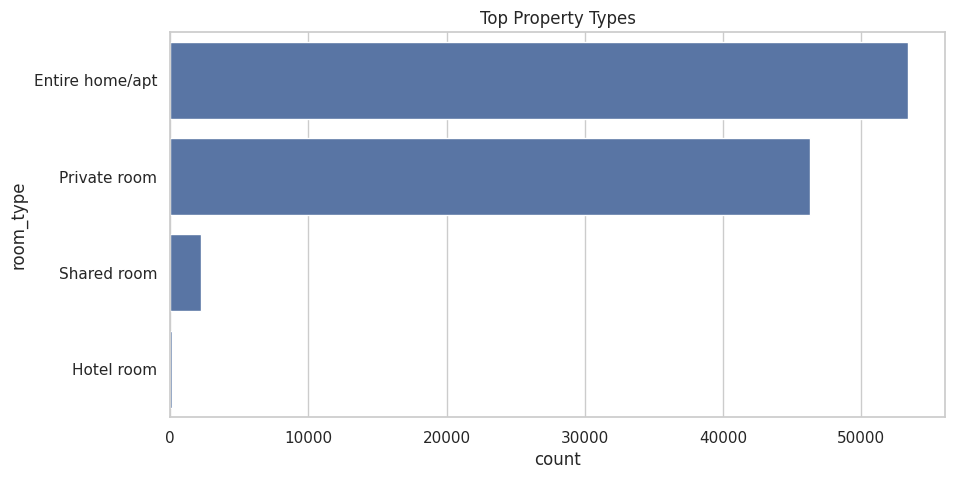

In [3]:
rt = cols_map['room_type']
print("Q1: Property Types\n")
print(df[rt].value_counts().head(10))
sns.countplot(y=rt, data=df, order=df[rt].value_counts().index[:10])
plt.title("Top Property Types")
plt.show()


2.Which neighborhood group has the highest number of listings?

Q2: Neighbourhood Group Counts

neighbourhood_group
Manhattan        43557
Brooklyn         41630
Queens           13197
Bronx             2694
Staten Island      949
unknown             29
manhatan             1
brookln              1
Name: count, dtype: int64


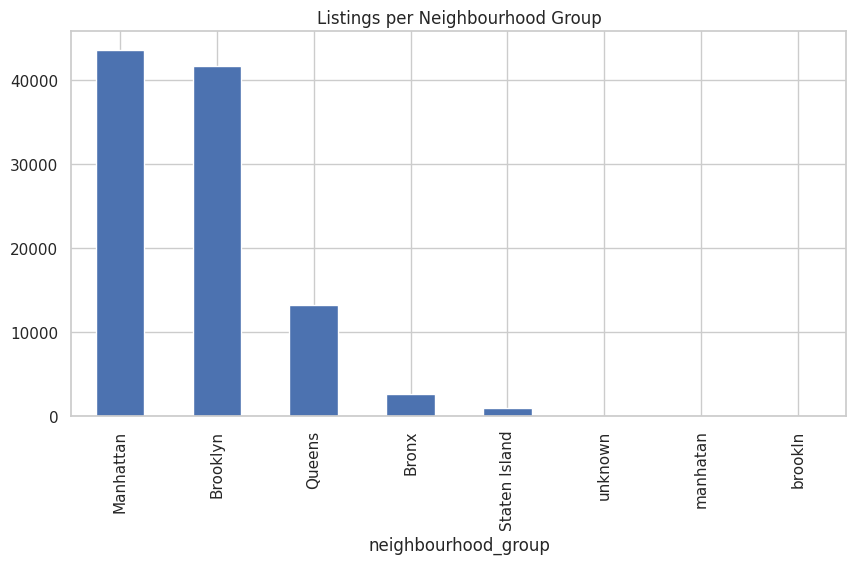

In [4]:
ng = cols_map['neighbourhood_group']
print("Q2: Neighbourhood Group Counts\n")
print(df[ng].value_counts())
df[ng].value_counts().plot(kind="bar")
plt.title("Listings per Neighbourhood Group")
plt.show()


3.Which neighborhoods group have the highest average prices for Airbnb listings?

Q3: Avg Price by Neighbourhood Group

neighbourhood_group
unknown          657.206897
Queens           630.203986
Bronx            627.757610
Brooklyn         626.498607
Staten Island    623.993678
Manhattan        622.656863
brookln          580.000000
manhatan         460.000000
Name: price, dtype: float64


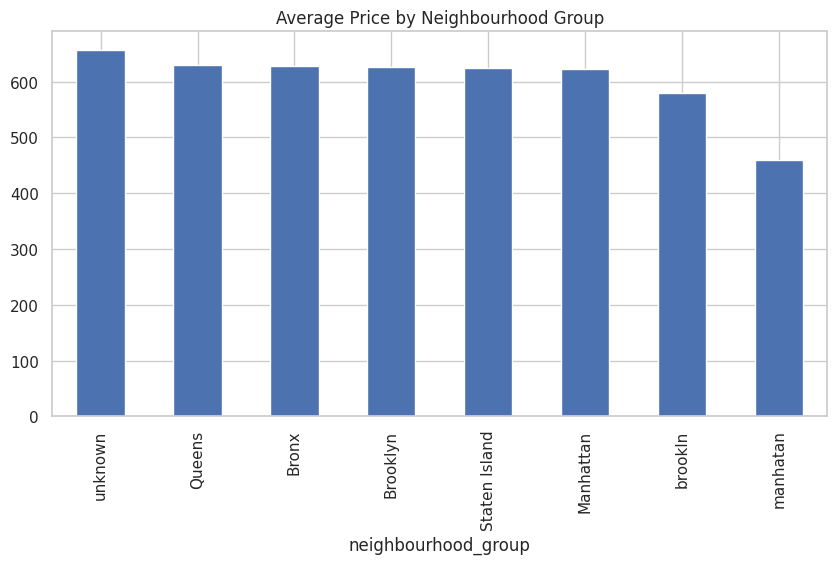

In [5]:
price_col = cols_map['price']
print("Q3: Avg Price by Neighbourhood Group\n")
avg_price = df.groupby(ng)[price_col].mean().sort_values(ascending=False)
print(avg_price)
avg_price.plot(kind="bar")
plt.title("Average Price by Neighbourhood Group")
plt.show()


4.Is there a relationship between the construction year of property and price?

Q4: Construction Year vs Price



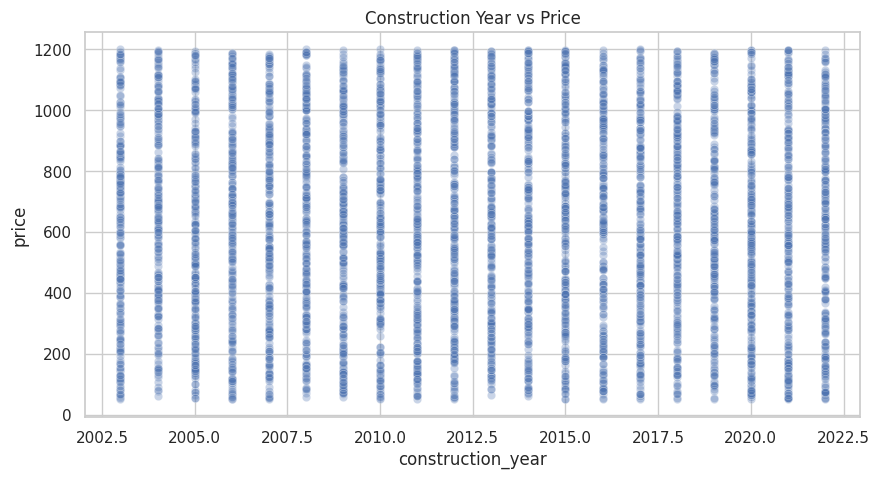

Correlation: -0.003699642297436768


In [6]:
cy = cols_map['construction_year']
print("Q4: Construction Year vs Price\n")
sns.scatterplot(x=cy, y=price_col, data=df.sample(min(5000,len(df)), random_state=1), alpha=0.3)
plt.title("Construction Year vs Price")
plt.show()
print("Correlation:", df[[cy,price_col]].corr().iloc[0,1])


5.Who are the top 10 hosts by calculated host listing count?

Q5: Top 10 Hosts

host_id
28199312869    332.0
70352033029    332.0
53394556356    332.0
90177049292    332.0
90148229302    332.0
46384126745    332.0
71519005437    332.0
97620664846    332.0
58398584635    332.0
76431087156    332.0
Name: calculated_host_listings_count, dtype: float64


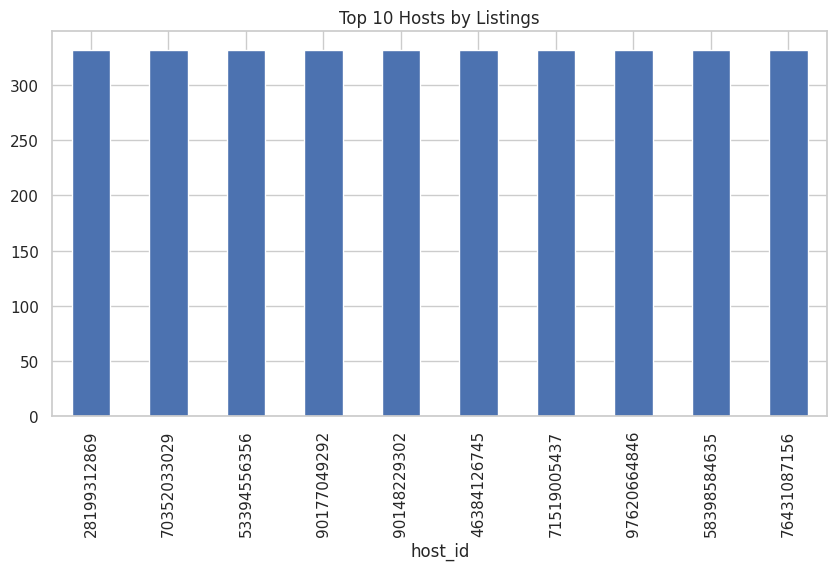

In [7]:
host_id = cols_map['host_id']
host_listings = cols_map['calculated_host_listings_count']
print("Q5: Top 10 Hosts\n")

if host_listings:
    top_hosts = df.groupby(host_id)[host_listings].max().sort_values(ascending=False).head(10)
else:
    top_hosts = df.groupby(host_id).size().sort_values(ascending=False).head(10)

print(top_hosts)
top_hosts.plot(kind="bar")
plt.title("Top 10 Hosts by Listings")
plt.show()


6.Are hosts with verified identities more likely to receive positive reviews

Q6: Verified Hosts vs Review Scores

host_identity_verified
unconfirmed    3.271141
unknown        3.224913
verified       3.284899
Name: review_rate_number, dtype: float64


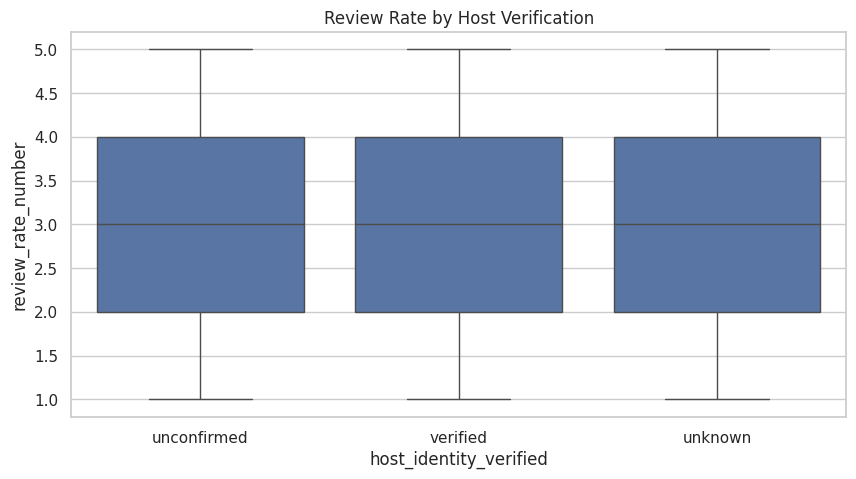

In [8]:
hid = cols_map['host_identity_verified']
rr = cols_map['review_rate_number']
print("Q6: Verified Hosts vs Review Scores\n")

print(df.groupby(hid)[rr].mean())
sns.boxplot(x=hid, y=rr, data=df)
plt.title("Review Rate by Host Verification")
plt.show()


7.Is there a correlation between the price of a listing and its service fee?

Q7: Price vs Service Fee



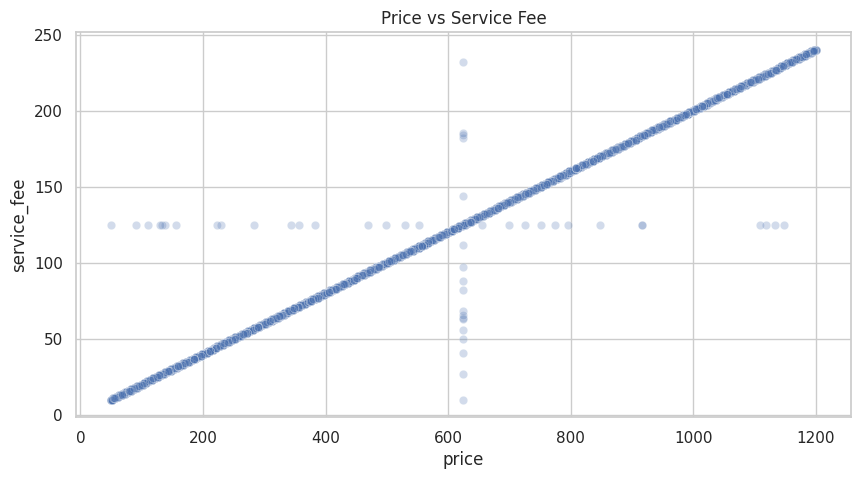

Correlation: 0.9978247509610382


In [9]:
sf = cols_map['service_fee']
print("Q7: Price vs Service Fee\n")

sns.scatterplot(x=price_col, y=sf, data=df.sample(min(10000,len(df)), random_state=2), alpha=0.25)
plt.title("Price vs Service Fee")
plt.show()
print("Correlation:", df[[price_col,sf]].corr().iloc[0,1])


8.What is the avyerage review rate number (e.g., stars) for listings, and does it vary based on the neighborhood group and room type?

Q8: Avg Review Scores by Neighbourhood & Room Type

room_type            Entire home/apt  Hotel room  Private room  Shared room
neighbourhood_group                                                        
Bronx                           3.34        0.00          3.32         3.26
Brooklyn                        3.25        3.86          3.26         3.33
Manhattan                       3.27        3.50          3.28         3.25
Queens                          3.35        3.75          3.31         3.37
Staten Island                   3.33        0.00          3.47         3.53
brookln                         0.00        0.00          4.00         0.00
manhatan                        0.00        0.00          3.00         0.00
unknown                         3.18        0.00          3.22         0.00


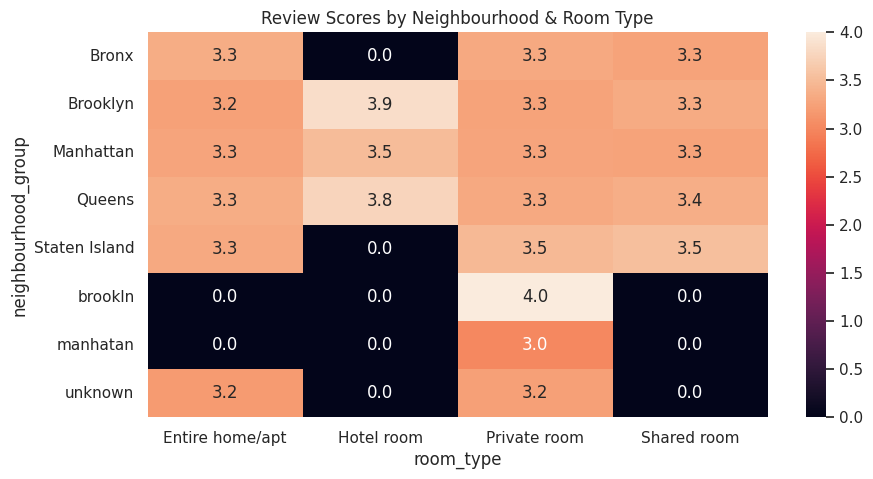

In [10]:
print("Q8: Avg Review Scores by Neighbourhood & Room Type\n")
pivot = df.groupby([ng,rt])[rr].mean().unstack().fillna(0)
print(pivot.round(2))
sns.heatmap(pivot, annot=True, fmt=".1f")
plt.title("Review Scores by Neighbourhood & Room Type")
plt.show()


9.Are hosts with a higher calculated host listings count more likely to maintain higher availability throughout the year?

Q9: Host Listings vs Availability

Correlation: 0.15868477409464346


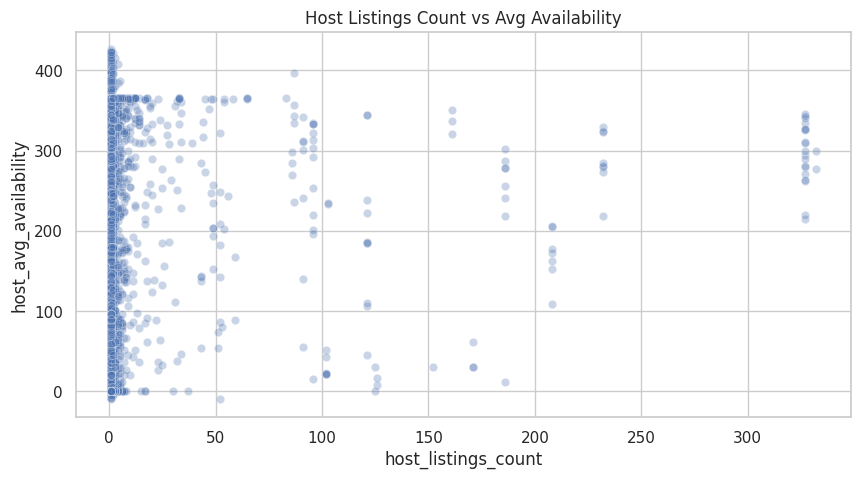

In [11]:
avail = cols_map['availability_365']
print("Q9: Host Listings vs Availability\n")

if host_listings:
    host_counts = df.groupby(host_id)[host_listings].max()
else:
    host_counts = df.groupby(host_id).size()

host_avail = df.groupby(host_id)[avail].mean()
host_df = pd.concat([host_counts, host_avail], axis=1).dropna()
host_df.columns = ['host_listings_count','host_avg_availability']

print("Correlation:", host_df.corr().iloc[0,1])
sns.scatterplot(x='host_listings_count', y='host_avg_availability',
                data=host_df.sample(min(3000,len(host_df)), random_state=3), alpha=0.3)
plt.title("Host Listings Count vs Avg Availability")
plt.show()
